In [1]:
#libraries
import torch
import models
import os
import yaml
import numpy as np
from PIL import Image
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist
import math
from skimage.metrics import structural_similarity as ssim
import torch.nn as nn
from torchvision.transforms import Resize
import cv2



In [2]:
device=torch.device('cuda')
torch.cuda.device_count()

3

In [3]:
def psnr(pred, out, rgb_range=1):
    '''
    inp: patch_count * channels * H * W
    pred: patch_count * channels * H * W
    '''
    diff = (pred - out)/ rgb_range
    mse = torch.mean(torch.pow(diff, 2))

    return -10 * torch.log10(mse)

In [4]:
# Setting up the Initial Parameters and Image Trasnform
dir = '/home/gpu/girish/results_clrimg_resized/_unet_basic_25_raw_test_patch'
amp = 25
split_ratio = 0
raw = True
monochrome= False
resize = False
train =  True

In [5]:
#! Patichyfies ? 

def patchify_img(image, patch_size=512):
    size_x = (image.shape[0] // patch_size) * patch_size  # get width to nearest size divisible by patch size
    size_y = (image.shape[1] // patch_size) * patch_size
    # print(size_x, size_y, image.shape[0], image.shape[1]) #!
    instances = []
    temp =image.shape
    # Crop original image to size divisible by patch size from top left corner
    image = image[:size_x, :size_y]

    # Extract patches from each image, step=patch_size means no overlap
    # print(image.shape)
    patch_img = patchify(image, (patch_size, patch_size), step=patch_size) # Built in Library 
    # print(patch_img.shape, image.shape, temp) # (4, 8, 1, 512, 512, 3) What does the third dimension represent? 
    
    """
    Total number of patches = 4 X 8 X 1 of size 512 X 512 X 3
    """

    # iterate over vertical patch axis
    for j in range(patch_img.shape[0]):
        # iterate over horizontal patch axis
        for k in range(patch_img.shape[1]):
            # patches are located like a grid. use (j, k) indices to extract single patched image
            single_patch_img = patch_img[j, k]

            # Drop extra extra dimension from patchify
            instances.append(np.squeeze(single_patch_img))
    return np.vstack([np.expand_dims(x, 0) for x in instances]), size_x, size_y, patch_img.shape[0], patch_img.shape[1]

In [6]:
#model construction
model_path = os.path.join(dir, 'epoch-30.pth')
sv_file = torch.load(model_path, map_location=device)
model = models.make(sv_file['model'], load_sd=True).eval().cuda()
model = nn.DataParallel(model)

In [7]:
# The Required Preprocessing 
""" 
Hmm. This code can be mereged with the visualzie_train/test
"""
def image_transform(img, amp=False, raw=False, output=False, resize = False):
    # Here where we should be working 
    if raw:
        """ 
        Experiment
        # """
        # # Loading the file 
        # arr = np.array(Image.open(img))
        # arr = torch.from_numpy(arr/255)
        # if output == False:
        #     raw_h, raw_w = arr.shape
        #     r = np.zeros((raw_h // 2, raw_w // 2, 1))
        #     g1 = np.zeros((raw_h // 2, raw_w // 2, 1))
        #     g2 = np.zeros((raw_h // 2, raw_w // 2, 1))
        #     b = np.zeros((raw_h // 2, raw_w // 2, 1))
        #     r = img[0::2, 0::2]  # r
        #     g1 = img[0::2, 1::2]  # gr
        #     g2 = img[1::2, 0::2]  # gb
        #     b = img[1::2, 1::2]  # b
        #     img_unpack = np.dstack((r, g1, g2, b)) 
        #     # print(img_unpack.shape, 'image unpack shape')
        #     if amp:
        #         img_unpack_amp = np.clip(img_unpack*amp,0,1)
        # else:
        #     img_unpack_amp = img
        # img_unpack_amp = np.transpose(img_unpack_amp , (2,0,1))        
        # # print(img_unpack_amp.shape, 'before resizing shape')
        # if resize:
        #     resizer = Resize([512,512])
        #     img_unpack_amp_resize = resizer(torch.from_numpy(img_unpack_amp))

        """ 
        The Original 
        """
        img = cv2.imread(img, -1)
        img = torch.from_numpy(img/255)
        # img = img / 255.0
        # Unpacking
        if output == False:
            # raw_h, raw_w = img.shape
            # r = np.zeros((raw_h // 2, raw_w // 2, 1))
            # g1 = np.zeros((raw_h // 2, raw_w // 2, 1))
            # g2 = np.zeros((raw_h // 2, raw_w // 2, 1))
            # b = np.zeros((raw_h // 2, raw_w // 2, 1))
            # r = img[0::2, 0::2]  # r
            # g1 = img[0::2, 1::2]  # gr
            # g2 = img[1::2, 0::2]  # gb
            # b = img[1::2, 1::2]  # b
            # img_arr = np.dstack((r, g1, g2, b)) 
            # img = torch.from_numpy(img_arr / 255).permute(2, 0, 1).unsqueeze(0)
            if amp:
                img_unpack_amp = (img*amp).clamp_(0,1)
            res, h, w, p_x, p_y = patchify_img(np.array(arr), patch_size=512)
            print(res.shape, 'res shape is in here')
        else:
            img = torch.from_numpy(img/255).permute(2, 0, 1).unsqueeze(0)
            img_unpack_amp = img
            
        if resize:
            resizer = Resize([512,512])
            img_unpack_amp_resize = resizer(img_unpack_amp)
        else:
            img_unpack_amp_resize = img_unpack_amp
        # print(img_unpack_amp_resize.shape, 'After resizing')
        
    else:
        arr = np.array(Image.open(img))
        if len(arr.shape)==3:
            pass
        elif len(arr.shape)==2:
            arr = np.repeat(np.expand_dims(arr, axis=2), 3, axis=2)
    # arr = torch.from_numpy(arr/255)
    # if amp:
        # print(arr.shape, 'Shape in here')
        # amp = amp_module(arr, 0.5)
        # amp_arr = (arr*amp).clamp_(0,1)
        # arr = amp_arr
    # res, h, w, p_x, p_y = patchify_img(np.array(arr), patch_size=512)
    # arr = torch.from_numpy(res).permute(0, 3, 1, 2)
    # if amp:
        # return arr, h, w, p_x, p_y, amp, amp_arr
    # else:
        # return arr, h, w, p_x, p_y
    return img_unpack_amp_resize
    

In [8]:
# #Load and processing the image - Train

# with open(os.path.join(dir, 'config.yaml'), 'r') as f:
#         config = yaml.load(f, Loader=yaml.FullLoader)
        
# if config['val_dataset']['dataset']['args'].get('root_path_inp') is not None:
#     test_dir = config['val_dataset']['dataset']['args']['root_path_inp']
#     out_dir = config['val_dataset']['dataset']['args']['root_path_out']
#     filenames = sorted(os.listdir(test_dir))
#     outfile = sorted(os.listdir(out_dir))
#     img_files = filenames[math.ceil(len(filenames)*split_ratio):]
#     print(len(img_files), len(filenames))
#     #img_files = filenames[0:]
#     imgs, h_s, w_s, pxs, pys, out_imgs = [], [], [], [], [], []
#     n = len(img_files)
#     img_files_first_half =img_files[:(n-1)//2]
#     img_files_second_half = img_files[(n-1)//2:]
#     print(len(img_files_first_half))
#     print(len(img_files_second_half))
#     for file in img_files_first_half: #! First Half alone
#         # res is patches of the image. Each Image is prolly split into 32 patches of size (512,512)
#         res = image_transform(os.path.join(test_dir,file), amp = amp, raw = raw, resize=resize) #! I think this converts the picture into patches of constant size. Here is where the error
#         # print(res[0].shape) #! torch.Size([32, 3, 512, 512]) few instances, it is (28, 3, 512, 512). Why? 
#         # print(os.path.join(test_dir,file), amp, raw)
#         if monochrome:
#             imgs.append(res[0][:,:1,:,:])
#         else:
#             imgs.append(res)
#         # h_s.append(res[1])
#         # w_s.append(res[2])
#         # pxs.append(res[3])
#         # pys.append(res[4])
#         out_imgs.append(image_transform(os.path.join(out_dir, file), raw=raw, output=True, resize=resize))
                       
# else:
#     test_dir1 = config['val_dataset']['dataset']['args']['root_path_inp1']
#     test_dir2 = config['val_dataset']['dataset']['args']['root_path_inp2']
#     out_dir = config['val_dataset']['dataset']['args']['root_path_out']
#     filenames = sorted(os.listdir(test_dir1))
#     img_files = filenames[math.ceil(len(filenames)*split_ratio):]
#     outfile = sorted(os.listdir(out_dir))
#     imgs, h_s, w_s, pxs, pys, out_imgs = [], [], [], [], [], []
    
#     for file in img_files:
#         res1 = image_transform(os.path.join(test_dir1, file), amp, raw)
#         res2 = image_transform(os.path.join(test_dir2, file), amp, raw)
    
#         if monochrome:
#             res = torch.cat([res1[0][:,:1,:,:], res2[0][:,:1,:,:]], axis=1)
#             imgs.append(res)
#         else:
#             res = torch.cat([res1[0], res2[0]], dim=1)
#             imgs.append(res)
#         h_s.append(res2[1])
#         w_s.append(res2[2])
#         pxs.append(res2[3])
#         pys.append(res2[4])
#         out_imgs.append(image_transform(os.path.join(out_dir, file), raw=raw, output=True)[0])


In [9]:
# Loading the Images and making the necessory transforms - Test Images


with open(os.path.join(dir, 'test_config.yaml'), 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
        
if config['test_dataset']['dataset']['args'].get('root_path_inp') is not None:
    test_dir = config['test_dataset']['dataset']['args']['root_path_inp']
    out_dir = config['test_dataset']['dataset']['args']['root_path_out']
    filenames = sorted(os.listdir(test_dir))
    outfile = sorted(os.listdir(out_dir))
    img_files = filenames[math.ceil(len(filenames)*split_ratio):]
    n = len(img_files)
    img_files_first_half =img_files[:(n-1)//2]
    img_files_second_half = img_files[(n-1)//2:]
    files = img_files_second_half
    print(len(img_files), len(filenames))
    # img_files = ['68.png', '162.png', '134.png', '173.png', '18.png', '184.png'] #! filenames
    imgs, h_s, w_s, pxs, pys, out_imgs = [], [], [], [], [], []
    for file in files:
        print(file)
        res = image_transform(os.path.join(test_dir,file), amp = amp, raw = raw, resize = resize)
        # print(res[0].shape)
        if monochrome:
            imgs.append(res[0][:,:1,:,:])
        else:
            imgs.append(res)
        # h_s.append(res[1])
        # w_s.append(res[2])
        # pxs.append(res[3])
        # pys.append(res[4])

        
        # Need to check if this required. I do not think it is. 
        # if amp:
            # amp_imgs.append(res[6])
            # avg_amp.append(res[5])
        out_imgs.append(image_transform(os.path.join(out_dir, file), raw=raw, output=True, resize=False))
                       
else:
    test_dir1 = config['test_dataset']['dataset']['args']['root_path_inp1']
    test_dir2 = config['test_dataset']['dataset']['args']['root_path_inp2']
    out_dir = config['test_dataset']['dataset']['args']['root_path_out']
    filenames = sorted(os.listdir(test_dir1))
    img_files = filenames[math.ceil(len(filenames)*split_ratio):]
    outfile = sorted(os.listdir(out_dir))
    imgs, h_s, w_s, pxs, pys, out_imgs = [], [], [], [], [], []
    
    for file in img_files:
        res1 = image_transform(os.path.join(test_dir1, file), amp, raw)
        res2 = image_transform(os.path.join(test_dir2, file), amp, raw)

    
        if monochrome:
            res = torch.cat([res1[0][:,:1,:,:], res2[0][:,:1,:,:]], axis=1)
            imgs.append(res)
        else:
            res = torch.cat([res1[0], res2[0]], dim=1)
            imgs.append(res)
        h_s.append(res2[1])
        w_s.append(res2[2])
        pxs.append(res2[3])
        pys.append(res2[4])
        out_imgs.append(image_transform(os.path.join(out_dir, file), raw=raw, output=True)[0])


30 30
2.png


AttributeError: 'numpy.ndarray' object has no attribute 'clamp_'

torch.Size([1, 4, 1080, 2048])


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/gpu/.local/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/home/gpu/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/gpu/girish/enhancement/models/unet.py", line 166, in forward
    d1 = self.d1(b, s4)
  File "/home/gpu/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/gpu/girish/enhancement/models/unet.py", line 106, in forward
    x = torch.cat([x, skip], axis=1)
RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 134 but got size 135 for tensor number 1 in the list.


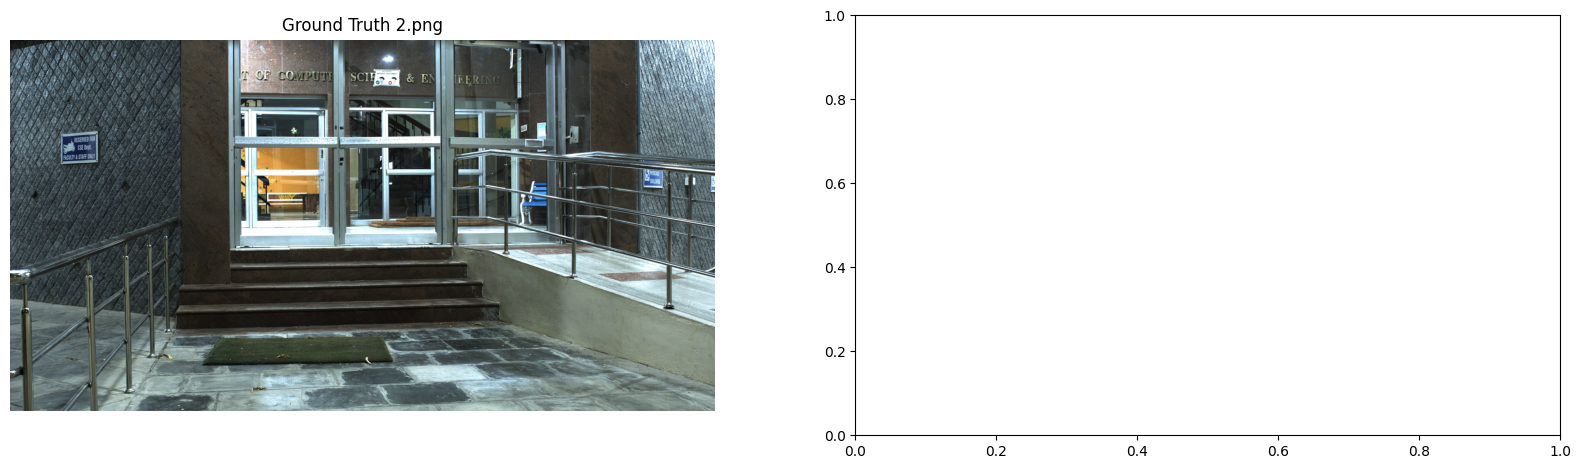

In [ ]:
for i in range(len(imgs)):
    file_name = files[i]
    plt.figure(figsize=(20,12))
    plt.subplot(2, 2, 1)
    gt = out_imgs[i]
    gt = torch.reshape(gt, (3, 2160, 4096))
    gt = torch.permute(gt, (1, 2 , 0)).detach().cpu().numpy()
    gt = gt[:, :, [2,1,0]]
    plt.title('Ground Truth {}'.format(file_name) )
    plt.imshow(gt, 'gray')
    plt.axis('off')

    plt.subplot(2,2,2)
    
    if resize:
        img = torch.reshape(imgs[i], (1, 4, 512, 512)).float()
    else:
        img = torch.reshape(imgs[i], (1, 4, 1080, 2048)).float()
    print(img.shape)
    pred = model(img)
    pred = torch.reshape(pred, (3, 512, 512))
    if resize:
        resizer = Resize([2160,4096])
        pred = resizer(pred)
    pred = torch.permute(pred, (1, 2 , 0)).detach().cpu().numpy()
    plt.title('Output')
    plt.imshow(pred, 'gray')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title('Difference Between Output and Input')
    plt.imshow(abs(gt - pred), 'gray')
    plt.axis('off')


    plt.subplots_adjust(wspace =0.01, hspace = 0.1)
    path ='/home/gpu/girish/enhancement/results'
    plt.savefig(os.path.join(path, file_name), )
    plt.show()
    


In [ ]:
# #predict
# results, psnrs, ssims = [], [], []
# for i, img in enumerate(imgs):
#     # pred_patches = []
#     # print(img.shape)
#     # for patch in img:
#     #     pred = model((patch.unsqueeze(0).float()-0.5)/0.5)
#     #     pred_patches.append((pred*0.5+0.5).clamp_(0,1).detach().cpu())
#     # pred = torch.vstack(pred_patches)
#     # psnrs.append(psnr(pred, out_imgs[i][:,:3,:,:]).item())
#     # result = unpatchify(pred.permute(0,2,3,1).reshape(pxs[0],pys[0],1,512,512,3).detach().numpy(), (h_s[0],w_s[0],3))
#     # results.append(result)
#     img = torch.reshape(img, (1, 4, 512, 512))
#     # plt.imshow(img)
#     # quit()
#     img = img.float()
#     # print(img)
#     pred = model(img)
#     # print(pred)
#     pred = torch.reshape(pred, (3, 512, 512))
#     pred = torch.permute(pred, (1, 2 , 0))
#     # print(pred.shape)
#     # pred = pred *50
#     # cv2.imwrite("/home/gpu/girish/enhancement/dummy/1.png",pred)
#     plt.imshow(pred.detach().cpu().numpy(), 'gray')
#     plt.show()
#     if i == 10: 
#         break

    

In [ ]:
# #predict
# results, psnrs, ssims = [], [], []
# for i, img in enumerate(out_imgs):
#     # pred_patches = []
#     # print(img.shape)
#     # for patch in img:
#     #     pred = model((patch.unsqueeze(0).float()-0.5)/0.5)
#     #     pred_patches.append((pred*0.5+0.5).clamp_(0,1).detach().cpu())
#     # pred = torch.vstack(pred_patches)
#     # psnrs.append(psnr(pred, out_imgs[i][:,:3,:,:]).item())
#     # result = unpatchify(pred.permute(0,2,3,1).reshape(pxs[0],pys[0],1,512,512,3).detach().numpy(), (h_s[0],w_s[0],3))
#     # results.append(result)
#     # img = torch.reshape(img, (1, 4, 512, 512))
#     # plt.imshow(img)
#     # quit()
#     # img = img.float()
#     # pred = model(img)
#     pred = img
#     pred = torch.reshape(pred, (3, 512, 512))
#     pred = torch.permute(pred, (1, 2 , 0))
#     print(pred.shape)
#     plt.imshow(pred.detach().cpu().numpy(), 'gray')
#     plt.show()
#     if i == 10: 
#         break

    